In [250]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, load_digits
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cpu


## --- 1. Model & Function Definitions ---

In [251]:
class Autoencoder(nn.Module):
    """
    Autoencoder with configurable architecture.
    
    Args:
        input_size: Dimension of input data
        bottleneck_size: Dimension of the bottleneck (code) layer
        hidden_size: Dimension of hidden layers
        layers: Number of hidden layers
    """
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers
        
        # Build encoder
        encoder_layers = []
        
        # First layer: input -> hidden
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(layers - 1):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
        
        # Last layer: hidden -> bottleneck (no activation)
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder (mirror of encoder)
        decoder_layers = []
        
        # First layer: bottleneck -> hidden
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(layers - 1):
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
        
        # Last layer: hidden -> output (no activation)
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed, z

---
## ResNet for Task 2

In [252]:
# --- Task 2 专用模型 ---

class ResNetBlock(nn.Module):
    """
    实现一个残差块: z_l = z_{l-1} + f_l(z_{l-1})
    """
    def __init__(self, size):
        super(ResNetBlock, self).__init__()
        # f_l (一个简单的2层网络)
        self.block = nn.Sequential(
            nn.Linear(size, size),
            nn.ReLU(),
            nn.Linear(size, size)
        )
    
    def forward(self, x):
        # z_l = z_{l-1} + f_l(z_{l-1})
        return x + self.block(x)

class ResNetAutoencoder(nn.Module):
    """
    使用 ResNet 架构的自编码器 (用于 Task 2).
    """
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(ResNetAutoencoder, self).__init__()
        
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers # 这里的 layers 指的是 ResNetBlock 的数量
        
        # --- Build Encoder ---
        encoder_layers = []
        # 1. Input layer: input -> hidden
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        # 2. ResNet Blocks: hidden -> hidden
        for _ in range(layers):
            encoder_layers.append(ResNetBlock(hidden_size))
            encoder_layers.append(nn.ReLU())
        # 3. Bottleneck layer: hidden -> bottleneck
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # --- Build Decoder (mirror) ---
        decoder_layers = []
        # 1. Input layer: bottleneck -> hidden
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())
        # 2. ResNet Blocks: hidden -> hidden
        for _ in range(layers):
            decoder_layers.append(ResNetBlock(hidden_size))
            decoder_layers.append(nn.ReLU())
        # 3. Output layer: hidden -> input
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        reconstructed = self.decode(z)
        return reconstructed, z

In [253]:
def train_autoencoder(model, train_data, epochs=100, lr=0.001, batch_size=64,verbose=True):
    """
    Train an autoencoder using MSE reconstruction loss with mini-batching.
    
    Args:
        model: Autoencoder model
        train_data: Training data (numpy array or tensor)
        epochs: Number of training epochs
        lr: Learning rate
        batch_size: Size of mini-batches
        verbose: Whether to print training progress
        batch_size: Size of mini-batches
        
    Returns:
        losses: List of average training loss per epoch
    """
    
    if isinstance(train_data, np.ndarray):
        train_data = torch.FloatTensor(train_data)
    
    
    dataset = TensorDataset(train_data)
    
    train_loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    epoch_losses = []
    
    
    for epoch in range(epochs):
        model.train()
        total_epoch_loss = 0.0 
        
        for batch in train_loader:
            inputs = batch[0].to(device) 
            
            # Forward pass
            reconstructed, codes = model(inputs)

            # Compute loss
            loss = criterion(reconstructed, inputs)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_epoch_loss += loss.item()
            
        avg_epoch_loss = total_epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.6f}")
            
    return epoch_losses

## --- Task 1: 2D Moons Data (Bottleneck=1) ---

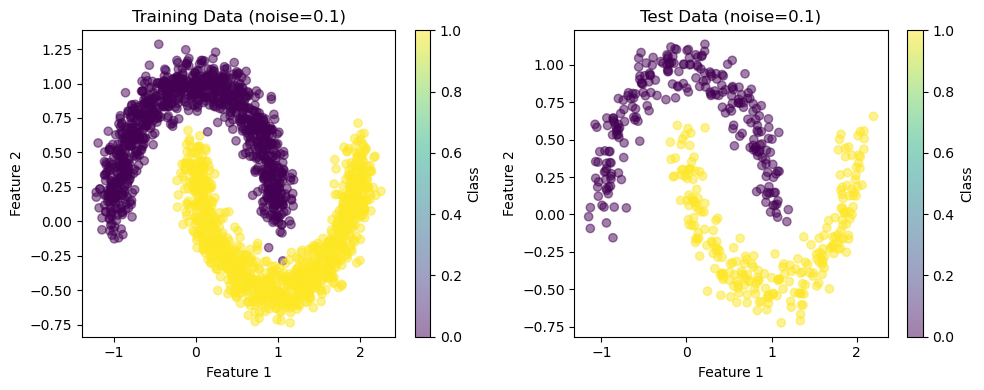

In [254]:
#generate two moons dataset with noise level 0.1


n_samples = 2000
X_train,y_train = make_moons(n_samples=n_samples,noise=0.1,random_state=42)
X_test,y_test = make_moons(n_samples=500,noise=0.1,random_state=43)

#visualize data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5)
plt.title('Training Data (noise=0.1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.title('Test Data (noise=0.1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.tight_layout()
plt.show()





---
## quick test

Epoch [10/10], Loss: 0.461375


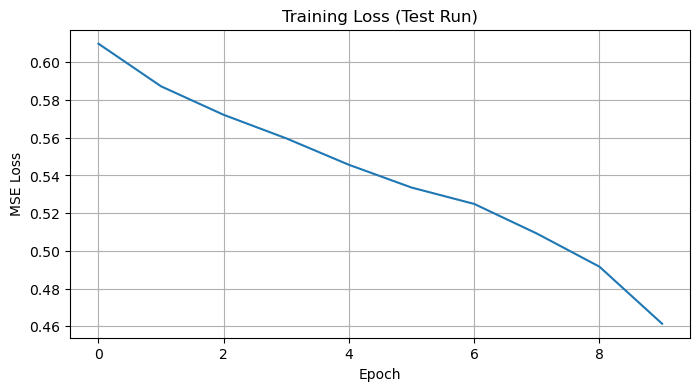

In [255]:
# Test with small configuration first
model_test = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=8, layers=2)
losses_test = train_autoencoder(model_test, X_train[:1000], epochs=10, lr=0.001,batch_size=64)

plt.figure(figsize=(8, 4))
plt.plot(losses_test)
plt.title('Training Loss (Test Run)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [256]:
# Define hyperparameter ranges
hidden_sizes = [4, 8, 16, 32]
layer_counts = [1, 2, 3, 4]
training_sizes = [500, 1000, 2000]
batch_sizes = [16, 32, 64, 128, 256]

# Store results
results = {}

# Experiment with hidden_size
print("Experimenting with hidden_size...")
test_errors_hidden = []
for hidden_size in hidden_sizes:
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=2)
    train_autoencoder(model, X_train, epochs=100, lr=0.001, batch_size=64, verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        test_errors_hidden.append(test_error)
        print(f"  hidden_size={hidden_size}: test_error={test_error:.6f}")

results['hidden_sizes'] = (hidden_sizes, test_errors_hidden)

Experimenting with hidden_size...
  hidden_size=4: test_error=0.079490
  hidden_size=8: test_error=0.035293
  hidden_size=16: test_error=0.035844
  hidden_size=32: test_error=0.010916


In [257]:
# Experiment with number of layers
print("\nExperimenting with number of layers...")
test_errors_layers = []
for num_layers in layer_counts:
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=16, layers=num_layers)
    train_autoencoder(model, X_train, epochs=100, batch_size=64,lr=0.001, verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        test_errors_layers.append(test_error)
        print(f"  layers={num_layers}: test_error={test_error:.6f}")

results['layer_counts'] = (layer_counts, test_errors_layers)


Experimenting with number of layers...
  layers=1: test_error=0.037834
  layers=2: test_error=0.023044
  layers=3: test_error=0.014723
  layers=4: test_error=0.021161


In [258]:
# Experiment with training set size
print("\nExperimenting with training set size...")
test_errors_trainsize = []
for train_size in training_sizes:
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=2)
    train_autoencoder(model, X_train[:train_size], epochs=100, batch_size=64,lr=0.001, verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        test_errors_trainsize.append(test_error)
        print(f"  train_size={train_size}: test_error={test_error:.6f}")

results['training_sizes'] = (training_sizes, test_errors_trainsize)


Experimenting with training set size...
  train_size=500: test_error=0.033133
  train_size=1000: test_error=0.015720
  train_size=2000: test_error=0.008600


In [259]:
# Experiment with batch size
print("\nExperimenting with batch size...")
test_errors_batchsize = []
for b_size in batch_sizes:
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=2)
    train_autoencoder(model, X_train[:train_size], epochs=100, lr=0.001, batch_size=b_size,verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        test_errors_batchsize.append(test_error)
        print(f"  batch_size={train_size}: test_error={test_error:.6f}")

results['batch_sizes'] = (batch_sizes, test_errors_batchsize)


Experimenting with batch size...
  batch_size=2000: test_error=0.008500
  batch_size=2000: test_error=0.008847
  batch_size=2000: test_error=0.009318
  batch_size=2000: test_error=0.015123
  batch_size=2000: test_error=0.032011


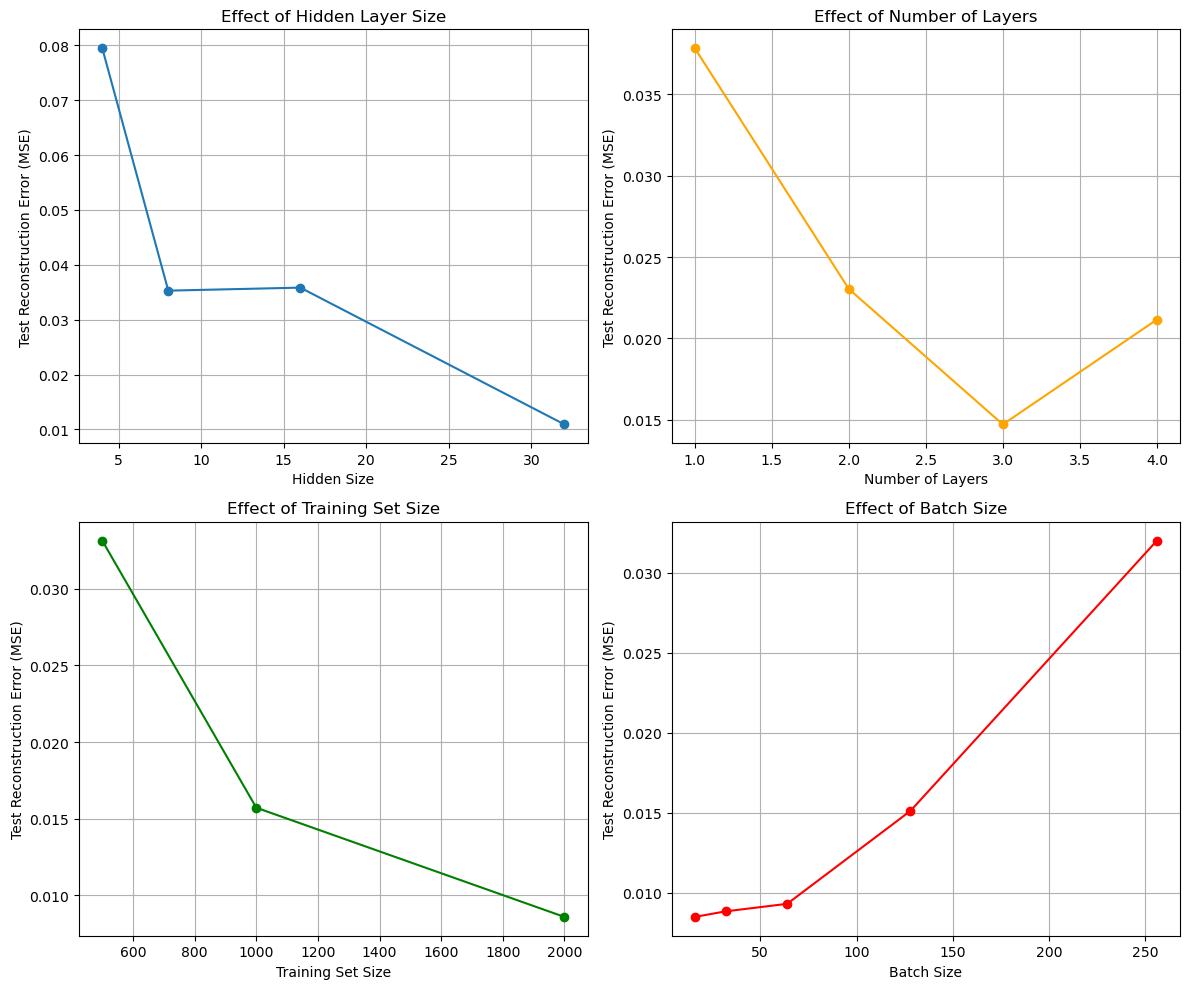

In [260]:
# Plot hyperparameter effects
# *** MODIFIED: Changed to 2x2 grid ***
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(hidden_sizes, test_errors_hidden, marker='o')
axes[0, 0].set_xlabel('Hidden Size')
axes[0, 0].set_ylabel('Test Reconstruction Error (MSE)')
axes[0, 0].set_title('Effect of Hidden Layer Size')
axes[0, 0].grid(True)

axes[0, 1].plot(layer_counts, test_errors_layers, marker='o', color='orange')
axes[0, 1].set_xlabel('Number of Layers')
axes[0, 1].set_ylabel('Test Reconstruction Error (MSE)')
axes[0, 1].set_title('Effect of Number of Layers')
axes[0, 1].grid(True)

axes[1, 0].plot(training_sizes, test_errors_trainsize, marker='o', color='green')
axes[1, 0].set_xlabel('Training Set Size')
axes[1, 0].set_ylabel('Test Reconstruction Error (MSE)')
axes[1, 0].set_title('Effect of Training Set Size')
axes[1, 0].grid(True)


axes[1, 1].plot(batch_sizes, test_errors_batchsize, marker='o', color='red')
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].set_ylabel('Test Reconstruction Error (MSE)')
axes[1, 1].set_title('Effect of Batch Size')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

---
## select best model

Epoch [10/200], Loss: 0.048749
Epoch [20/200], Loss: 0.037090
Epoch [30/200], Loss: 0.032856
Epoch [40/200], Loss: 0.027519
Epoch [50/200], Loss: 0.020218
Epoch [60/200], Loss: 0.016698
Epoch [70/200], Loss: 0.012400
Epoch [80/200], Loss: 0.010896
Epoch [90/200], Loss: 0.010157
Epoch [100/200], Loss: 0.009436
Epoch [110/200], Loss: 0.008658
Epoch [120/200], Loss: 0.008144
Epoch [130/200], Loss: 0.008014
Epoch [140/200], Loss: 0.007602
Epoch [150/200], Loss: 0.007699
Epoch [160/200], Loss: 0.007384
Epoch [170/200], Loss: 0.007357
Epoch [180/200], Loss: 0.007457
Epoch [190/200], Loss: 0.006837
Epoch [200/200], Loss: 0.006696


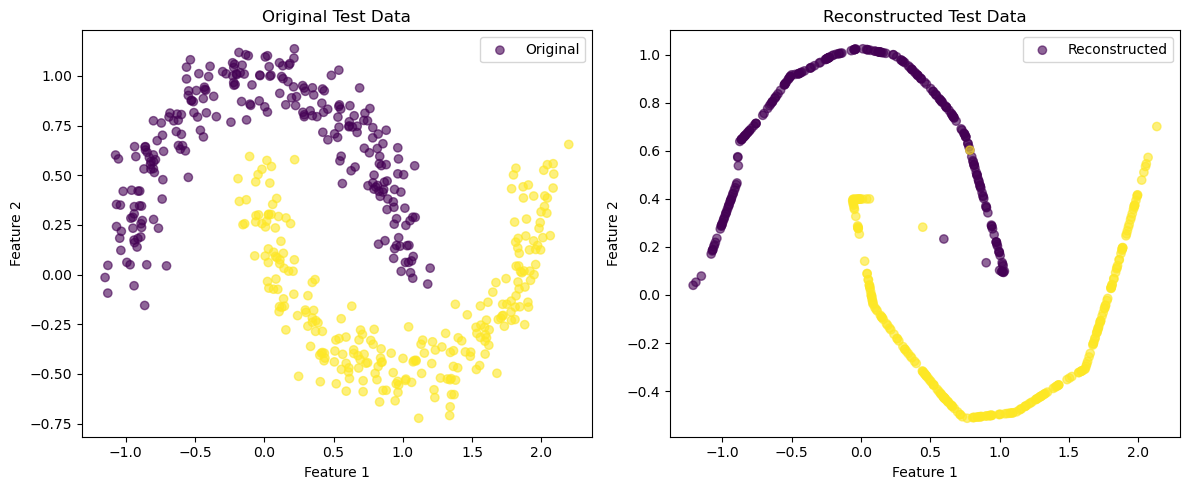

In [261]:
# Train best model based on experiments
best_model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=2)
train_autoencoder(best_model, X_train, epochs=200, lr=0.001, batch_size=64, verbose=True)

# Get reconstructions
best_model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    X_test_reconstructed, codes_test = best_model(X_test_tensor)
    X_test_reconstructed = X_test_reconstructed.cpu().numpy()
    codes_test = codes_test.cpu().numpy()

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.6, label='Original')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Test Data')
axes[0].legend()

axes[1].scatter(X_test_reconstructed[:, 0], X_test_reconstructed[:, 1], c=y_test, cmap='viridis', alpha=0.6, label='Reconstructed')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Reconstructed Test Data')
axes[1].legend()

plt.tight_layout()
plt.show()

In [262]:
# Train on same dataset multiple times
n_runs = 5
errors_same_data = []

print("Training on same dataset multiple times...")
for i in range(n_runs):
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=2)
    train_autoencoder(model, X_train, epochs=200, lr=0.001, batch_size=64, verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        errors_same_data.append(test_error)
        print(f"  Run {i+1}: test_error={test_error:.6f}")

print(f"\nMean error: {np.mean(errors_same_data):.6f}")
print(f"Std error: {np.std(errors_same_data):.6f}")

Training on same dataset multiple times...
  Run 1: test_error=0.007645
  Run 2: test_error=0.007042
  Run 3: test_error=0.007595
  Run 4: test_error=0.008000
  Run 5: test_error=0.006707

Mean error: 0.007398
Std error: 0.000462


In [263]:
# Train on different datasets multiple times
errors_diff_data = []

print("\nTraining on different datasets...")
for i in range(n_runs):
    X_train_new, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=100+i)
    model = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=32, layers=2)

    train_autoencoder(model, X_train_new, epochs=200, lr=0.001, batch_size=64, verbose=False)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        reconstructed, _ = model(X_test_tensor)
        test_error = nn.MSELoss()(reconstructed, X_test_tensor).item()
        errors_diff_data.append(test_error)
        print(f"  Run {i+1}: test_error={test_error:.6f}")

print(f"\nMean error: {np.mean(errors_diff_data):.6f}")
print(f"Std error: {np.std(errors_diff_data):.6f}")


Training on different datasets...
  Run 1: test_error=0.009079
  Run 2: test_error=0.008631
  Run 3: test_error=0.010235
  Run 4: test_error=0.011002
  Run 5: test_error=0.016021

Mean error: 0.010994
Std error: 0.002650


---
## visualize variability and distribution

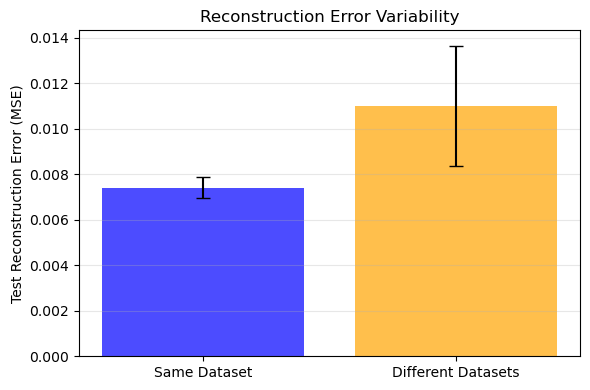


**Observations:**
- When training on the same dataset, the error is...[add your observation]
- When training on different datasets, the error is...[add your observation]


In [264]:
# Visualize variability
fig, ax = plt.subplots(figsize=(6, 4))

x_pos = [1, 2]
means = [np.mean(errors_same_data), np.mean(errors_diff_data)]
stds = [np.std(errors_same_data), np.std(errors_diff_data)]

ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['blue', 'orange'])
ax.set_xticks(x_pos)
ax.set_xticklabels(['Same Dataset', 'Different Datasets'])
ax.set_ylabel('Test Reconstruction Error (MSE)')
ax.set_title('Reconstruction Error Variability')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Observations:**")
print("- When training on the same dataset, the error is...[add your observation]")
print("- When training on different datasets, the error is...[add your observation]")

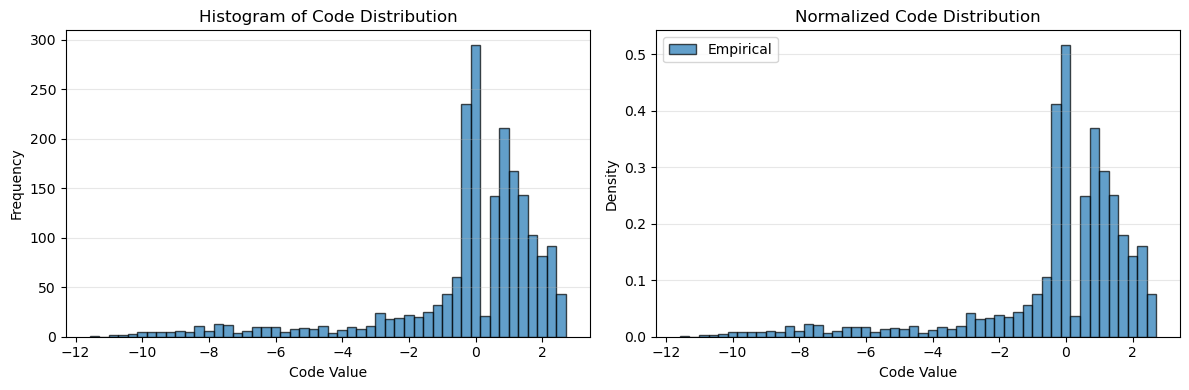

In [265]:
# Get code distribution
best_model.eval()
with torch.no_grad():
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    _, codes_train = best_model(X_train_tensor)
    codes_train = codes_train.cpu().numpy().flatten()

# Visualize code distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(codes_train, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Code Value')
plt.ylabel('Frequency')
plt.title('Histogram of Code Distribution')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(codes_train, bins=50, alpha=0.7, edgecolor='black', density=True, label='Empirical')
plt.xlabel('Code Value')
plt.ylabel('Density')
plt.title('Normalized Code Distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

GMM means: [ 0.5996125 -5.0719666]
GMM covariances: [1.0359628 8.118811 ]
GMM weights: [0.85484546 0.14515455]


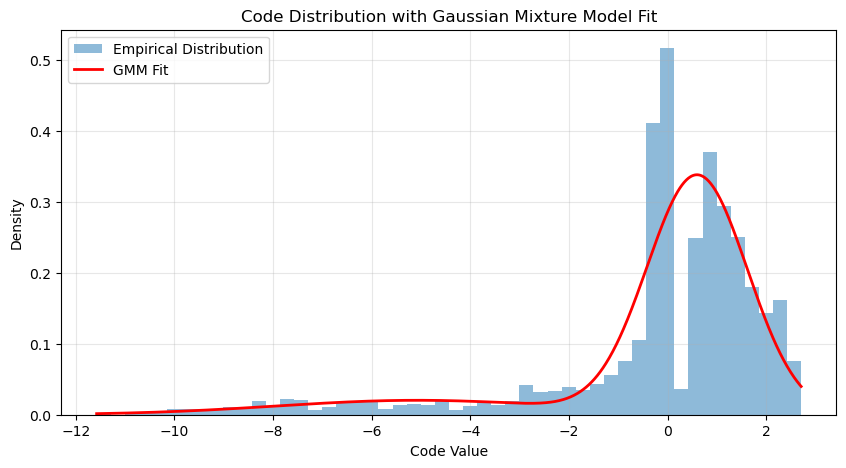

In [266]:
# Fit Gaussian Mixture Model
n_components = 2  # Two moons suggest two components。 maybe try more components later.
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(codes_train.reshape(-1, 1))

print(f"GMM means: {gmm.means_.flatten()}")
print(f"GMM covariances: {gmm.covariances_.flatten()}")
print(f"GMM weights: {gmm.weights_}")

# Plot GMM fit
x_range = np.linspace(codes_train.min(), codes_train.max(), 1000)
gmm_density = np.exp(gmm.score_samples(x_range.reshape(-1, 1)))

plt.figure(figsize=(10, 5))
plt.hist(codes_train, bins=50, alpha=0.5, density=True, label='Empirical Distribution')
plt.plot(x_range, gmm_density, 'r-', linewidth=2, label='GMM Fit')
plt.xlabel('Code Value')
plt.ylabel('Density')
plt.title('Code Distribution with Gaussian Mixture Model Fit')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

GMM means: [ 1.2421988  -6.847498   -1.3930308  -0.14507459]
GMM covariances: [0.45064354 4.0425086  1.444285   0.01960688]
GMM weights: [0.51686454 0.08877907 0.16071832 0.23363805]


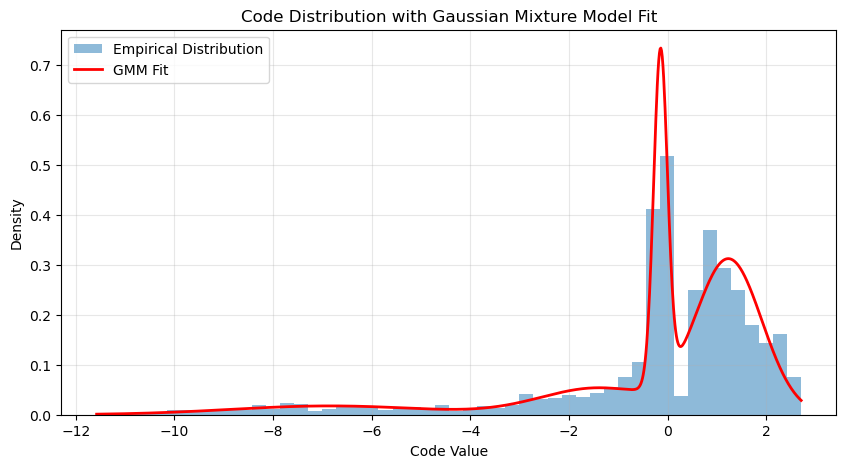

In [267]:
# Fit Gaussian Mixture Model
n_components = 4  # Two moons suggest two components。 maybe try more components later.
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(codes_train.reshape(-1, 1))

print(f"GMM means: {gmm.means_.flatten()}")
print(f"GMM covariances: {gmm.covariances_.flatten()}")
print(f"GMM weights: {gmm.weights_}")

# Plot GMM fit
x_range = np.linspace(codes_train.min(), codes_train.max(), 1000)
gmm_density = np.exp(gmm.score_samples(x_range.reshape(-1, 1)))

plt.figure(figsize=(10, 5))
plt.hist(codes_train, bins=50, alpha=0.5, density=True, label='Empirical Distribution')
plt.plot(x_range, gmm_density, 'r-', linewidth=2, label='GMM Fit')
plt.xlabel('Code Value')
plt.ylabel('Density')
plt.title('Code Distribution with Gaussian Mixture Model Fit')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

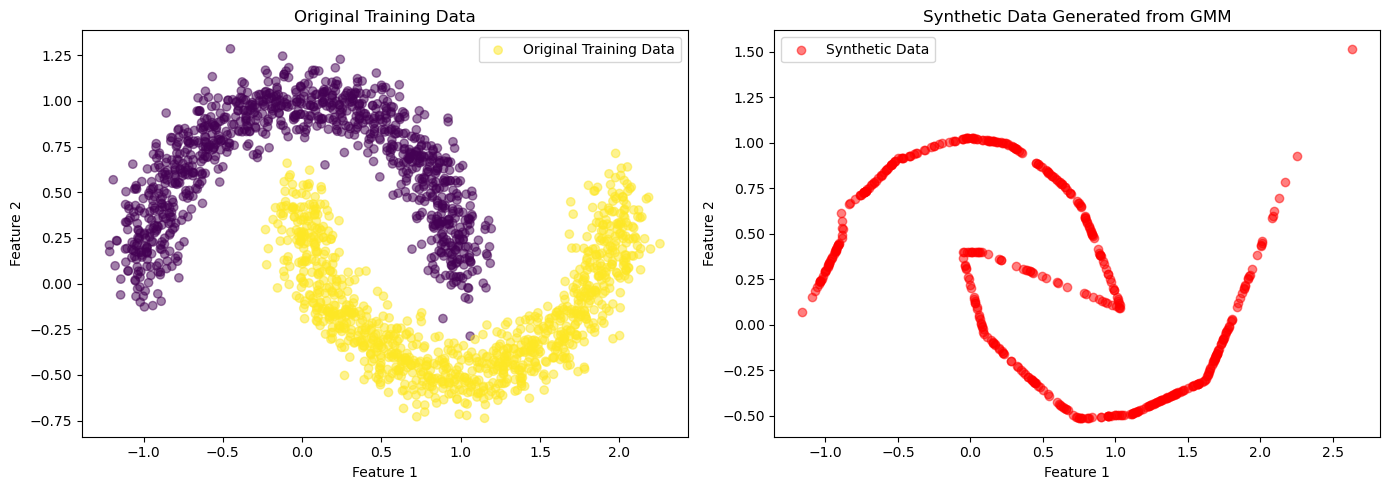


**Quality Assessment:**
The synthetic data shows... [add your observation about quality]


In [268]:
# Generate synthetic data
n_synthetic = 500
synthetic_codes, _ = gmm.sample(n_synthetic)

# Decode synthetic codes
best_model.eval()
with torch.no_grad():
    synthetic_codes_tensor = torch.FloatTensor(synthetic_codes).to(device)
    synthetic_data = best_model.decode(synthetic_codes_tensor)
    synthetic_data = synthetic_data.cpu().numpy()

# Visualize synthetic data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5, label='Original Training Data')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Training Data')
axes[0].legend()

axes[1].scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, color='red', label='Synthetic Data')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Synthetic Data Generated from GMM')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n**Quality Assessment:**")
print("The synthetic data shows... [add your observation about quality]")

Test error on noise=0.1: 0.008600
Test error on noise=0.2: 0.047390


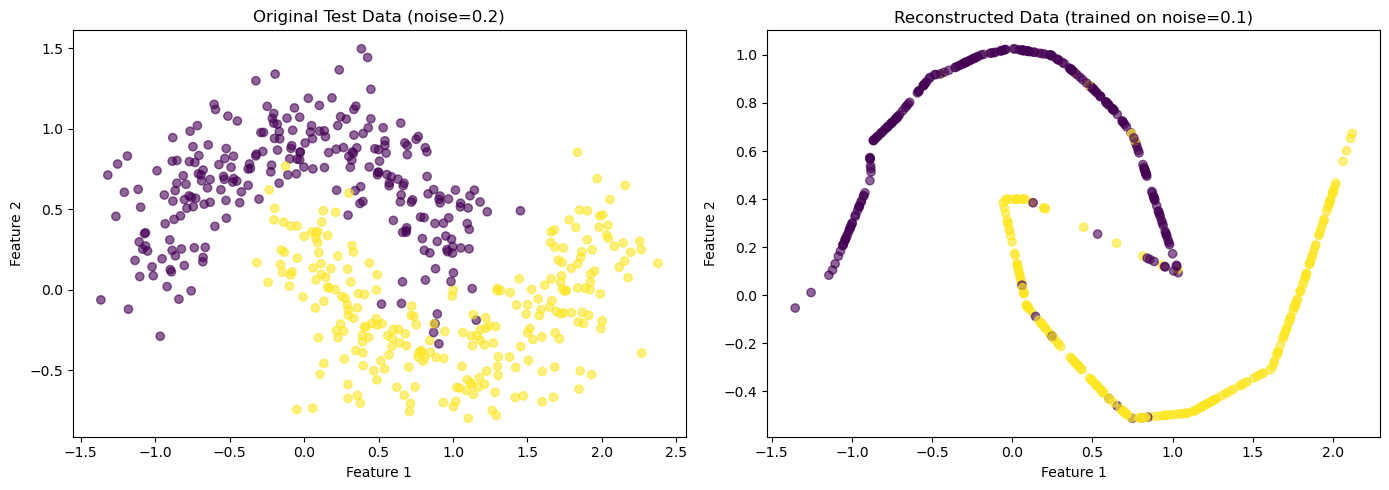


**Observations:**
The autoencoder still works because... [add your observation]


In [269]:
# Generate test set with noise level 0.2
X_test_noise02, y_test_noise02 = make_moons(n_samples=500, noise=0.2, random_state=44)

# Test the model (trained on noise 0.1) on noise 0.2 data
best_model.eval()
with torch.no_grad():
    X_test_noise02_tensor = torch.FloatTensor(X_test_noise02).to(device)
    X_reconstructed_noise02, _ = best_model(X_test_noise02_tensor)
    X_reconstructed_noise02 = X_reconstructed_noise02.cpu().numpy()
    
    test_error_noise02 = nn.MSELoss()(torch.FloatTensor(X_reconstructed_noise02), 
                                       torch.FloatTensor(X_test_noise02)).item()

print(f"Test error on noise=0.1: {results['training_sizes'][1][-1]:.6f}") # Get error from last training size
print(f"Test error on noise=0.2: {test_error_noise02:.6f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_test_noise02[:, 0], X_test_noise02[:, 1], c=y_test_noise02, cmap='viridis', alpha=0.6)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Test Data (noise=0.2)')

axes[1].scatter(X_reconstructed_noise02[:, 0], X_reconstructed_noise02[:, 1], 
                c=y_test_noise02, cmap='viridis', alpha=0.6)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Reconstructed Data (trained on noise=0.1)')

plt.tight_layout()
plt.show()

print("\n**Observations:**")
print("The autoencoder still works because... [add your observation]")

Epoch [10/150], Loss: 0.098734
Epoch [20/150], Loss: 0.061799
Epoch [30/150], Loss: 0.054072
Epoch [40/150], Loss: 0.050426
Epoch [50/150], Loss: 0.046938
Epoch [60/150], Loss: 0.043609
Epoch [70/150], Loss: 0.040626
Epoch [80/150], Loss: 0.038900
Epoch [90/150], Loss: 0.036925
Epoch [100/150], Loss: 0.035893
Epoch [110/150], Loss: 0.034282
Epoch [120/150], Loss: 0.033400
Epoch [130/150], Loss: 0.032720
Epoch [140/150], Loss: 0.031344
Epoch [150/150], Loss: 0.030718


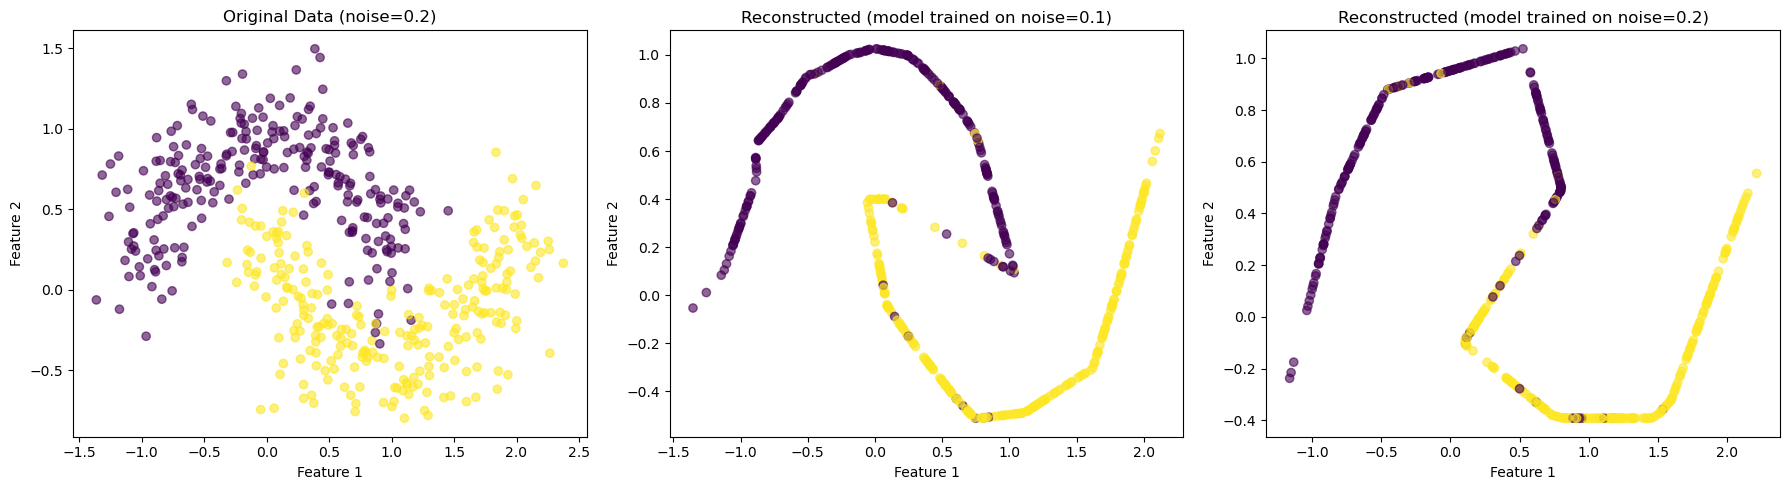


**Observations on Geometry:**
When trained on higher noise, the geometry changes in that... [add your observation]


In [270]:
# Generate training set with noise level 0.2
X_train_noise02, y_train_noise02 = make_moons(n_samples=2000, noise=0.2, random_state=45)

# Train new model on noise 0.2 data
model_noise02 = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=16, layers=2)
train_autoencoder(model_noise02, X_train_noise02, epochs=150, lr=0.001, batch_size=64, verbose=True)

# Test and visualize
model_noise02.eval()
with torch.no_grad():
    X_test_noise02_tensor = torch.FloatTensor(X_test_noise02).to(device)
    X_reconstructed_new, _ = model_noise02(X_test_noise02_tensor)
    X_reconstructed_new = X_reconstructed_new.cpu().numpy()

# Visualize geometry changes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_test_noise02[:, 0], X_test_noise02[:, 1], c=y_test_noise02, cmap='viridis', alpha=0.6)
axes[0].set_title('Original Data (noise=0.2)')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

axes[1].scatter(X_reconstructed_noise02[:, 0], X_reconstructed_noise02[:, 1], 
                c=y_test_noise02, cmap='viridis', alpha=0.6)
axes[1].set_title('Reconstructed (model trained on noise=0.1)')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

axes[2].scatter(X_reconstructed_new[:, 0], X_reconstructed_new[:, 1], 
                c=y_test_noise02, cmap='viridis', alpha=0.6)
axes[2].set_title('Reconstructed (model trained on noise=0.2)')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

print("\n**Observations on Geometry:**")
print("When trained on higher noise, the geometry changes in that... [add your observation]")

---
# TASK2

In [271]:
def compute_kernel(x, y, bandwidths):
    """
    Compute kernel matrix using multiple bandwidths.
    Uses inverse multiquadratic kernel: k(x,y) = sum_sigma C / (C + ||x-y||^2 / sigma^2)
    
    Args:
        x, y: Input tensors of shape (n, d)
        bandwidths: List of bandwidth values
    
    Returns:
        Kernel matrix
    """
    x = x.unsqueeze(1)  # (n, 1, d)
    y = y.unsqueeze(0)  # (1, m, d)
    
    distances_sq = torch.sum((x - y) ** 2, dim=2)  # (n, m)
    
    kernel_sum = 0
    C = 1.0
    
    for bandwidth in bandwidths:
        kernel_sum += C / (C + distances_sq / (bandwidth ** 2))
    
    return kernel_sum


def mmd_loss(z, bandwidths):
    """
    Compute Maximum Mean Discrepancy between code distribution and standard normal.
    
    Args:
        z: Encoded samples (n, d)
        bandwidths: List of bandwidth values for the kernel
    
    Returns:
        MMD loss value
    """
    # Sample from standard normal
    z_prior = torch.randn_like(z)
    
    # Compute kernel matrices
    k_zz = compute_kernel(z, z, bandwidths)
    k_zpzp = compute_kernel(z_prior, z_prior, bandwidths)
    k_zzp = compute_kernel(z, z_prior, bandwidths)
    
    # Compute MMD^2
    n = z.shape[0]
    mmd_sq = k_zz.sum() / (n * n) + k_zpzp.sum() / (n * n) - 2 * k_zzp.sum() / (n * n)
    
    return mmd_sq

---
## use ResNet or Autoencoder

In [272]:

def train_mmd_autoencoder(model, train_data, epochs=100, lr=0.001, 
                          mmd_weight=1.0, bandwidths=[0.5, 1.0, 2.0], 
                          batch_size=64, verbose=True):
    """
    Train an autoencoder with MMD regularization with mini-batching.   should train at the noise level 0.1,and implement ResNet
    """
    
    # 1. 转换数据并创建 DataLoader
    if isinstance(train_data, np.ndarray):
        train_data = torch.FloatTensor(train_data)
        
    dataset = TensorDataset(train_data)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 2. 将模型移动到设备
    model = model.to(device)
    
    # 3. 设置优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_criterion = nn.MSELoss()
    
    losses = {'total': [], 'reconstruction': [], 'mmd': []}
    
    # 4. 外循环：遍历 Epochs
    for epoch in range(epochs):
        model.train()
        
        epoch_total_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_mmd_loss = 0.0
        
        # 5. 内循环：遍历 Mini-Batches
        for batch in train_loader:
            inputs = batch[0].to(device)
            
            # --- 前向传播 ---
            reconstructed, codes = model(inputs)
            
            # --- 计算损失 ---
            recon_loss = mse_criterion(reconstructed, inputs)
            mmd = mmd_loss(codes, bandwidths)
            total_loss = recon_loss + mmd_weight * mmd
            
            # --- 反向传播 ---
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_mmd_loss += mmd.item()
            
        # 6. 计算并存储这个 epoch 的平均损失
        avg_total_loss = epoch_total_loss / len(train_loader)
        avg_recon_loss = epoch_recon_loss / len(train_loader)
        avg_mmd_loss = epoch_mmd_loss / len(train_loader)
        
        losses['total'].append(avg_total_loss)
        losses['reconstruction'].append(avg_recon_loss)
        losses['mmd'].append(avg_mmd_loss)
            
        # 7. 打印进度
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Total: {avg_total_loss:.6f}, "
                  f"Recon: {avg_recon_loss:.6f}, MMD: {avg_mmd_loss:.6f}")
            
    return losses

In [273]:
# Train autoencoder with bottleneck_size=2 and MMD loss
model_mmd = ResNetAutoencoder(input_size=2, bottleneck_size=2, hidden_size=32, layers=3)
# Experiment with different bandwidths
bandwidths = [0.5, 1.0, 2.0, 4.0, 8.0]
mmd_weight = 10.0  # Weight for MMD loss

# 
losses_mmd = train_mmd_autoencoder(model_mmd, X_train, epochs=300, lr=0.001,
                                   mmd_weight=mmd_weight, bandwidths=bandwidths,
                                   batch_size=256, verbose=True)

Epoch [20/300], Total: 0.458169, Recon: 0.006895, MMD: 0.045127
Epoch [40/300], Total: 0.329744, Recon: 0.006915, MMD: 0.032283
Epoch [60/300], Total: 0.353992, Recon: 0.006299, MMD: 0.034769
Epoch [80/300], Total: 0.338025, Recon: 0.002770, MMD: 0.033526
Epoch [100/300], Total: 0.290771, Recon: 0.002880, MMD: 0.028789
Epoch [120/300], Total: 0.296761, Recon: 0.001083, MMD: 0.029568
Epoch [140/300], Total: 0.219327, Recon: 0.007544, MMD: 0.021178
Epoch [160/300], Total: 0.240162, Recon: 0.002055, MMD: 0.023811
Epoch [180/300], Total: 0.215145, Recon: 0.002635, MMD: 0.021251
Epoch [200/300], Total: 0.233099, Recon: 0.003619, MMD: 0.022948
Epoch [220/300], Total: 0.208008, Recon: 0.003229, MMD: 0.020478
Epoch [240/300], Total: 0.136262, Recon: 0.001551, MMD: 0.013471
Epoch [260/300], Total: 0.148217, Recon: 0.002384, MMD: 0.014583
Epoch [280/300], Total: 0.236191, Recon: 0.003426, MMD: 0.023277
Epoch [300/300], Total: 0.256786, Recon: 0.003685, MMD: 0.025310


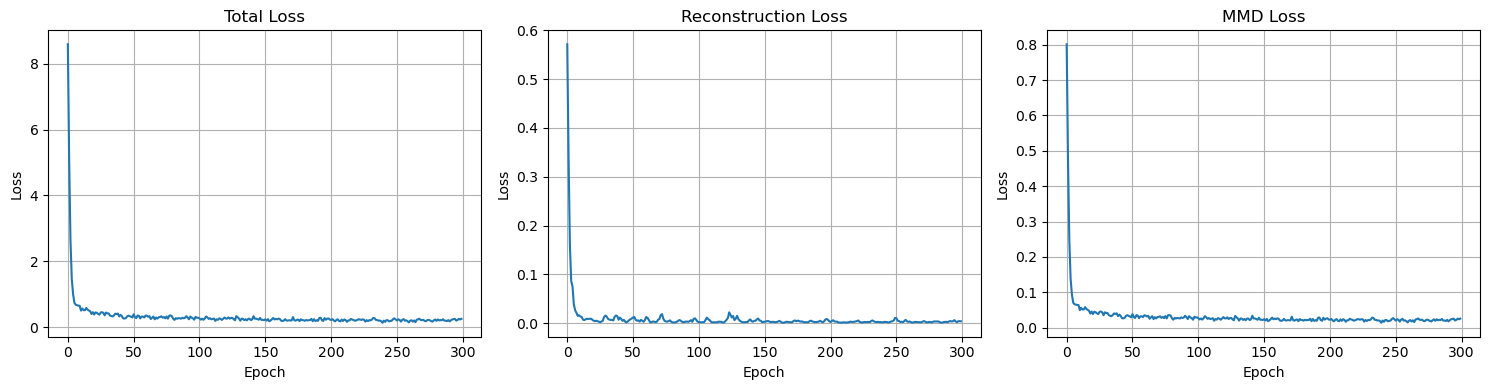

In [274]:
# Plot training losses
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(losses_mmd['total'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss')
axes[0].grid(True)

axes[1].plot(losses_mmd['reconstruction'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].grid(True)

axes[2].plot(losses_mmd['mmd'])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('MMD Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()

## visualization and analysis

Reconstruction error (bottleneck=2, with MMD): 0.003956
Compare to bottleneck=1 error: 0.008600
MMD (BN=2) model has LOWER reconstruction error than standard (BN=1) model.


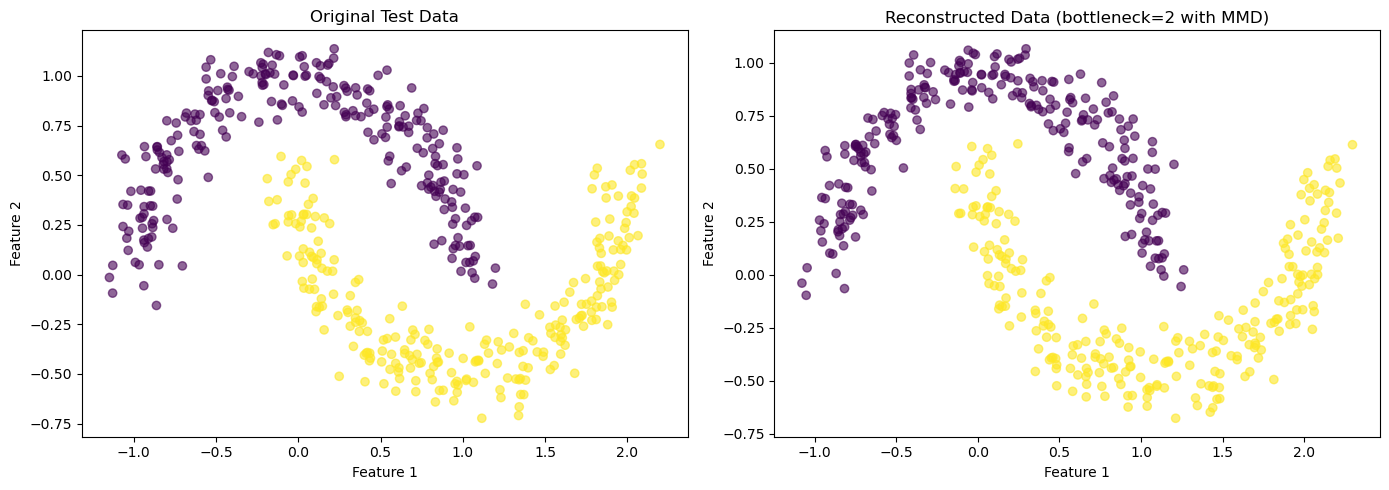

In [275]:
# Get reconstructions and codes.  i need to compare different bottleneck size and the difference
model_mmd.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    X_test_recon_mmd, codes_test_mmd = model_mmd(X_test_tensor)
    X_test_recon_mmd = X_test_recon_mmd.cpu().numpy()
    codes_test_mmd = codes_test_mmd.cpu().numpy()
    
    recon_error_mmd = nn.MSELoss()(torch.FloatTensor(X_test_recon_mmd),
                                   torch.FloatTensor(X_test)).item()

print(f"Reconstruction error (bottleneck=2, with MMD): {recon_error_mmd:.6f}")

if 'training_sizes' in results:
    # 从 Task 1 的实验中获取 BN=1 的误差
    bn1_error = results['training_sizes'][1][-1] # Get error from last training size
    print(f"Compare to bottleneck=1 error: {bn1_error:.6f}")
    if recon_error_mmd < bn1_error:
        print("MMD (BN=2) model has LOWER reconstruction error than standard (BN=1) model.")
    else:
        print("MMD (BN=2) model has HIGHER reconstruction error.")
else:
    print("Run Task 1 experiments to compare bottleneck=1 error.")

# Visualize reconstructions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', alpha=0.6)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Test Data')

axes[1].scatter(X_test_recon_mmd[:, 0], X_test_recon_mmd[:, 1], c=y_test, cmap='viridis', alpha=0.6)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Reconstructed Data (bottleneck=2 with MMD)')

plt.tight_layout()
plt.show()

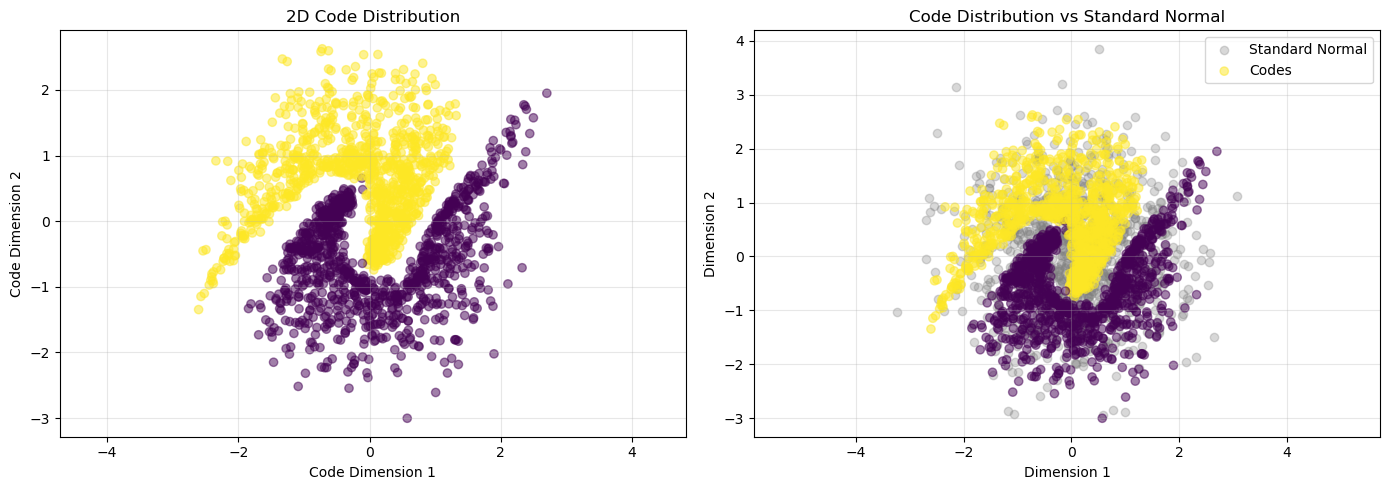

In [276]:
# Visualize code distribution
model_mmd.eval()
with torch.no_grad():
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    _, codes_train_mmd = model_mmd(X_train_tensor)
    codes_train_mmd = codes_train_mmd.cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2D scatter of codes
axes[0].scatter(codes_train_mmd[:, 0], codes_train_mmd[:, 1], c=y_train, cmap='viridis', alpha=0.5)
axes[0].set_xlabel('Code Dimension 1')
axes[0].set_ylabel('Code Dimension 2')
axes[0].set_title('2D Code Distribution')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Compare to standard normal
normal_samples = np.random.randn(1000, 2)
axes[1].scatter(normal_samples[:, 0], normal_samples[:, 1], alpha=0.3, label='Standard Normal', color='gray')
axes[1].scatter(codes_train_mmd[:, 0], codes_train_mmd[:, 1], c=y_train, cmap='viridis', alpha=0.5, label='Codes')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')
axes[1].set_title('Code Distribution vs Standard Normal')
axes[1].axis('equal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Generate synthetic data

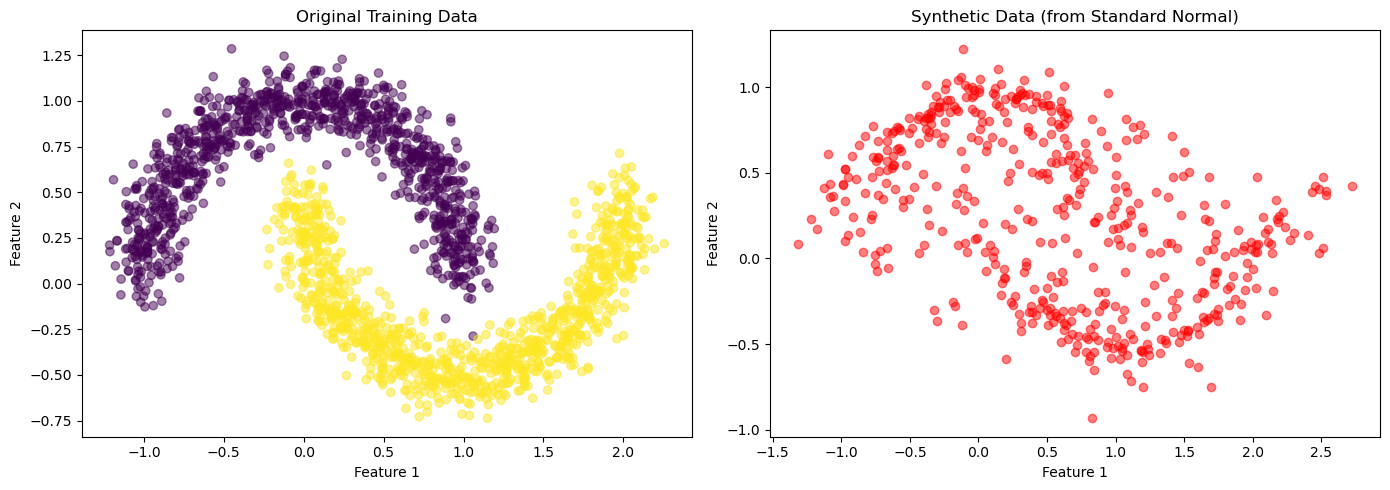


**Quality Assessment:**
The synthetic data quality is... [add your observations]
Compared to Task 1, this approach... [add comparison]


In [277]:
# Generate synthetic data by sampling from standard normal. 
n_synthetic = 500
synthetic_codes_normal = np.random.randn(n_synthetic, 2)

# Decode
model_mmd.eval()
with torch.no_grad():
    synthetic_codes_tensor = torch.FloatTensor(synthetic_codes_normal).to(device)
    synthetic_data_mmd = model_mmd.decode(synthetic_codes_tensor)
    synthetic_data_mmd = synthetic_data_mmd.cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', alpha=0.5)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Training Data')

axes[1].scatter(synthetic_data_mmd[:, 0], synthetic_data_mmd[:, 1], alpha=0.5, color='red')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Synthetic Data (from Standard Normal)')

plt.tight_layout()
plt.show()

print("\n**Quality Assessment:**")
print("The synthetic data quality is... [add your observations]")
print("Compared to Task 1, this approach... [add comparison]")

---
# Task 3

Training set size: (1257, 64)
Test set size: (540, 64)
Input dimension: 64


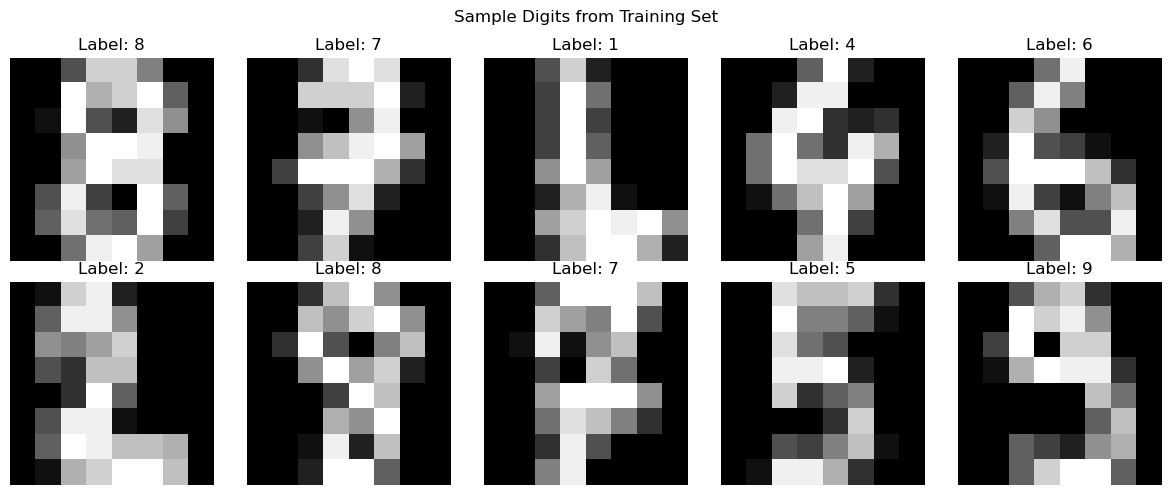

In [278]:
# Load digits dataset
digits = load_digits()
X_digits = digits.data / 16.0  # Normalize to [0, 1]
y_digits = digits.target

# Split into train and test
from sklearn.model_selection import train_test_split
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    X_digits, y_digits, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train_digits.shape}")
print(f"Test set size: {X_test_digits.shape}")
print(f"Input dimension: {X_train_digits.shape[1]}")

# Visualize some digits
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_digits[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Label: {y_train_digits[i]}")
    ax.axis('off')
plt.suptitle('Sample Digits from Training Set')
plt.tight_layout()
plt.show()

---
## Train models with differnet bottleneck_size

In [279]:
bottleneck_sizes = [2, 4, 8]
models_digits = {}
reconstructions = {}
codes = {}
errors = {}

for bn_size in bottleneck_sizes:
    print(f"\n{'='*60}")
    print(f"Training autoencoder with bottleneck_size={bn_size}")
    print(f"{'='*60}")
    
    model = Autoencoder(input_size=64, bottleneck_size=bn_size, 
                       hidden_size=128, layers=3)
    
    train_autoencoder(model, X_train_digits, epochs=200, lr=0.001, batch_size=128, verbose=True)
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        # Evaluation is still done on the full test set at once
        X_test_tensor = torch.FloatTensor(X_test_digits).to(device)
        X_recon, z = model(X_test_tensor)
        X_recon = X_recon.cpu().numpy()
        z = z.cpu().numpy()
        
        error = nn.MSELoss()(torch.FloatTensor(X_recon), 
                            torch.FloatTensor(X_test_digits)).item()
    
    models_digits[bn_size] = model
    reconstructions[bn_size] = X_recon
    codes[bn_size] = z
    errors[bn_size] = error
    
    print(f"\nTest reconstruction error: {error:.6f}")


Training autoencoder with bottleneck_size=2
Epoch [10/200], Loss: 0.072452
Epoch [20/200], Loss: 0.062735
Epoch [30/200], Loss: 0.047243
Epoch [40/200], Loss: 0.041498
Epoch [50/200], Loss: 0.038329
Epoch [60/200], Loss: 0.035845
Epoch [70/200], Loss: 0.033807
Epoch [80/200], Loss: 0.032368
Epoch [90/200], Loss: 0.030905
Epoch [100/200], Loss: 0.029936
Epoch [110/200], Loss: 0.029074
Epoch [120/200], Loss: 0.028178
Epoch [130/200], Loss: 0.027656
Epoch [140/200], Loss: 0.027450
Epoch [150/200], Loss: 0.026648
Epoch [160/200], Loss: 0.026023
Epoch [170/200], Loss: 0.025661
Epoch [180/200], Loss: 0.025195
Epoch [190/200], Loss: 0.024902
Epoch [200/200], Loss: 0.024620

Test reconstruction error: 0.031377

Training autoencoder with bottleneck_size=4
Epoch [10/200], Loss: 0.071594
Epoch [20/200], Loss: 0.051799
Epoch [30/200], Loss: 0.034334
Epoch [40/200], Loss: 0.028471
Epoch [50/200], Loss: 0.025653
Epoch [60/200], Loss: 0.024084
Epoch [70/200], Loss: 0.022751
Epoch [80/200], Loss: 0.0

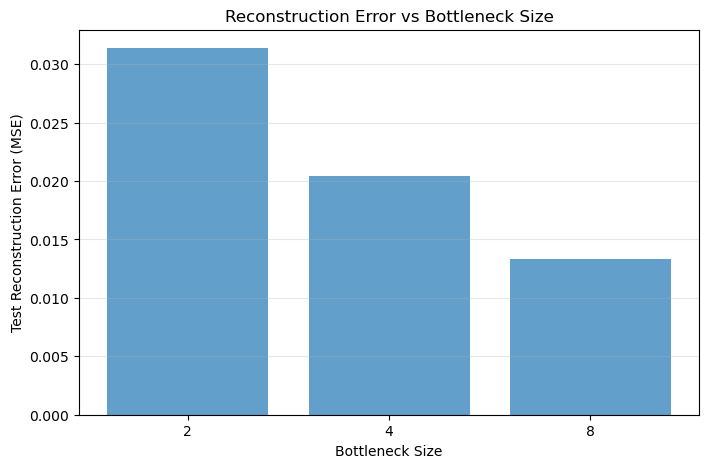


**Observations:**
As bottleneck size increases, the reconstruction error... [add observation]


In [280]:
# Plot reconstruction errors
plt.figure(figsize=(8, 5))
plt.bar([str(k) for k in bottleneck_sizes], [errors[k] for k in bottleneck_sizes], alpha=0.7)
plt.xlabel('Bottleneck Size')
plt.ylabel('Test Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs Bottleneck Size')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n**Observations:**")
print(f"As bottleneck size increases, the reconstruction error... [add observation]")

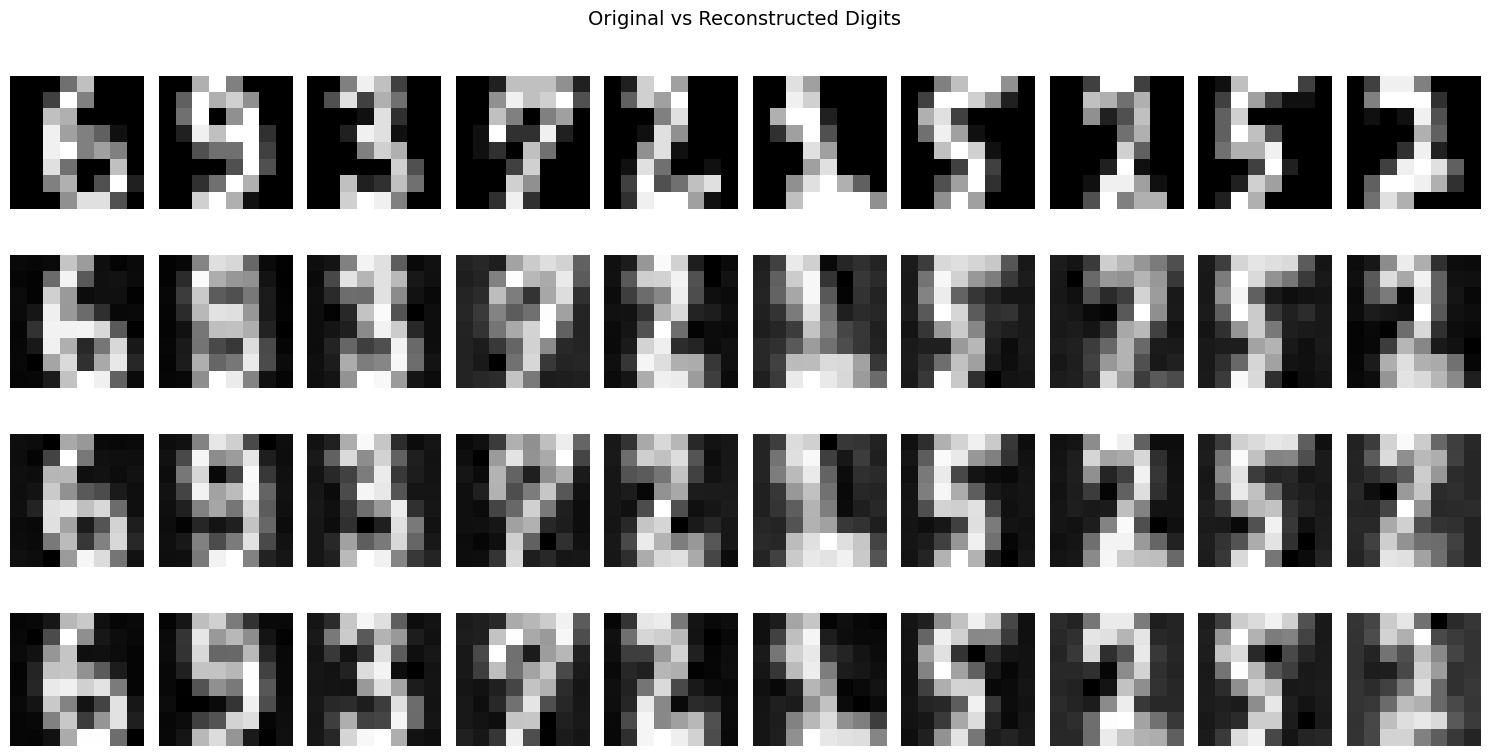

In [281]:
# Visualize original vs reconstructed digits
n_display = 10
fig, axes = plt.subplots(len(bottleneck_sizes) + 1, n_display, figsize=(15, 8))

# Original
for i in range(n_display):
    axes[0, i].imshow(X_test_digits[i].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, rotation=0, ha='right')

# Reconstructions
for row_idx, bn_size in enumerate(bottleneck_sizes, 1):
    for i in range(n_display):
        axes[row_idx, i].imshow(reconstructions[bn_size][i].reshape(8, 8), cmap='gray')
        axes[row_idx, i].axis('off')
        if i == 0:
            axes[row_idx, i].set_ylabel(f'BN={bn_size}', fontsize=12, rotation=0, ha='right')

plt.suptitle('Original vs Reconstructed Digits', fontsize=14)
plt.tight_layout()
plt.show()

In [282]:
# Train Random Forest classifier on original training data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_digits, y_train_digits)

# Test on original test data
y_pred_original = clf.predict(X_test_digits)
acc_original = accuracy_score(y_test_digits, y_pred_original)

print(f"Classifier accuracy on original test data: {acc_original:.4f}")

# Test on reconstructed data
print("\nClassifier accuracy on reconstructed test data:")
accuracies_recon = {}
for bn_size in bottleneck_sizes:
    y_pred_recon = clf.predict(reconstructions[bn_size])
    acc_recon = accuracy_score(y_test_digits, y_pred_recon)
    accuracies_recon[bn_size] = acc_recon
    print(f"  Bottleneck={bn_size}: {acc_recon:.4f}")

# Check label consistency
print("\nLabel consistency (original vs reconstructed):")
for bn_size in bottleneck_sizes:
    y_pred_recon = clf.predict(reconstructions[bn_size])
    consistency = np.mean(y_pred_original == y_pred_recon)
    print(f"  Bottleneck={bn_size}: {consistency:.4f}")

Classifier accuracy on original test data: 0.9759

Classifier accuracy on reconstructed test data:
  Bottleneck=2: 0.8407
  Bottleneck=4: 0.9130
  Bottleneck=8: 0.9370

Label consistency (original vs reconstructed):
  Bottleneck=2: 0.8481
  Bottleneck=4: 0.9130
  Bottleneck=8: 0.9481


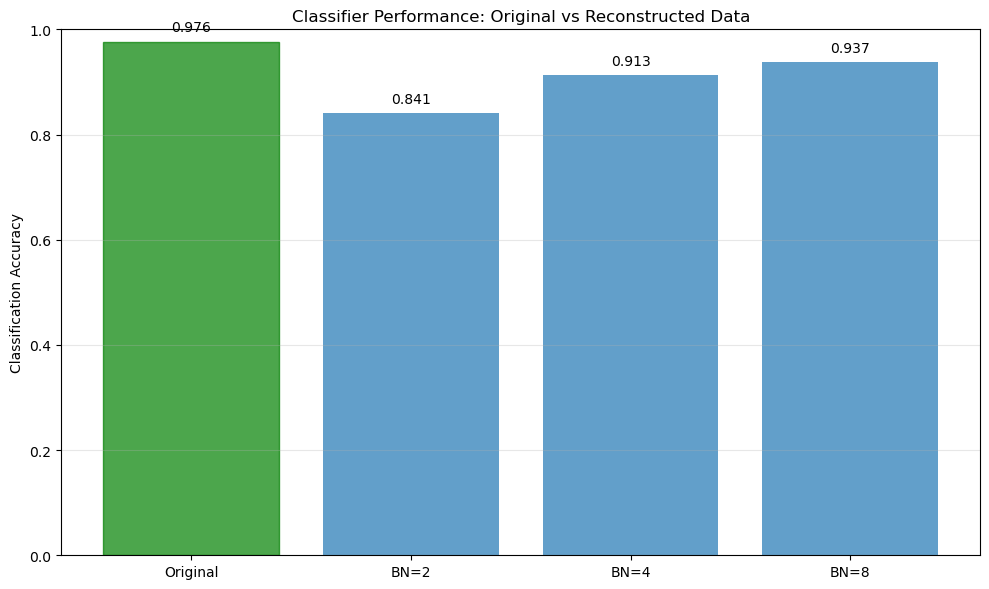

In [283]:
# Visualize accuracies
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = range(len(bottleneck_sizes) + 1)
labels = ['Original'] + [f'BN={bn}' for bn in bottleneck_sizes]
accs = [acc_original] + [accuracies_recon[bn] for bn in bottleneck_sizes]

bars = ax.bar(x_pos, accs, alpha=0.7)
bars[0].set_color('green')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Classification Accuracy')
ax.set_title('Classifier Performance: Original vs Reconstructed Data')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (x, acc) in enumerate(zip(x_pos, accs)):
    ax.text(x, acc + 0.02, f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Visualization Code Distribution


test code dimension with different bottleneck

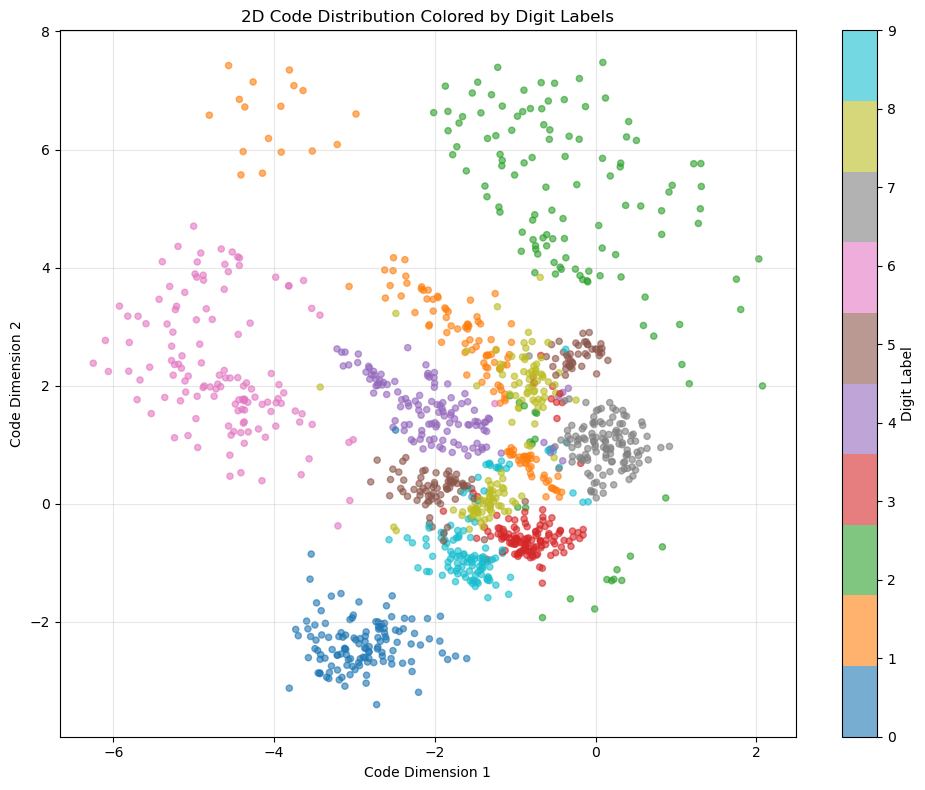


**Observations:**
The code distribution shows... [describe any interesting structure or clustering]


In [284]:
# Get codes for training data with bottleneck=2
model_bn2 = models_digits[2]
model_bn2.eval()
with torch.no_grad():
    X_train_tensor = torch.FloatTensor(X_train_digits).to(device)
    _, codes_train_bn2 = model_bn2(X_train_tensor)
    codes_train_bn2 = codes_train_bn2.cpu().numpy()

# Visualize colored by labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codes_train_bn2[:, 0], codes_train_bn2[:, 1], 
                     c=y_train_digits, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Code Dimension 1')
plt.ylabel('Code Dimension 2')
plt.title('2D Code Distribution Colored by Digit Labels')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n**Observations:**")
print("The code distribution shows... [describe any interesting structure or clustering]")

# Guassian Mixture Model and sythetic digit generalization

In [285]:
# Fit GMM for each bottleneck size
n_components = 10  # One for each digit
gmms = {}
synthetic_digits = {}

for bn_size in bottleneck_sizes:
    print(f"\nFitting GMM for bottleneck_size={bn_size}")
    
    # Get codes for training data
    model = models_digits[bn_size]
    model.eval()
    with torch.no_grad():
        X_train_tensor = torch.FloatTensor(X_train_digits).to(device)
        _, codes_train = model(X_train_tensor)
        codes_train = codes_train.cpu().numpy()
    
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(codes_train)
    gmms[bn_size] = gmm
    
    # Generate synthetic codes
    synthetic_codes, _ = gmm.sample(100)
    
    # Decode to get synthetic digits
    with torch.no_grad():
        synthetic_codes_tensor = torch.FloatTensor(synthetic_codes).to(device)
        synthetic_data = model.decode(synthetic_codes_tensor)
        synthetic_data = synthetic_data.cpu().numpy()
    
    synthetic_digits[bn_size] = synthetic_data
    print(f"Generated {len(synthetic_data)} synthetic digits")


Fitting GMM for bottleneck_size=2
Generated 100 synthetic digits

Fitting GMM for bottleneck_size=4
Generated 100 synthetic digits

Fitting GMM for bottleneck_size=8
Generated 100 synthetic digits


/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


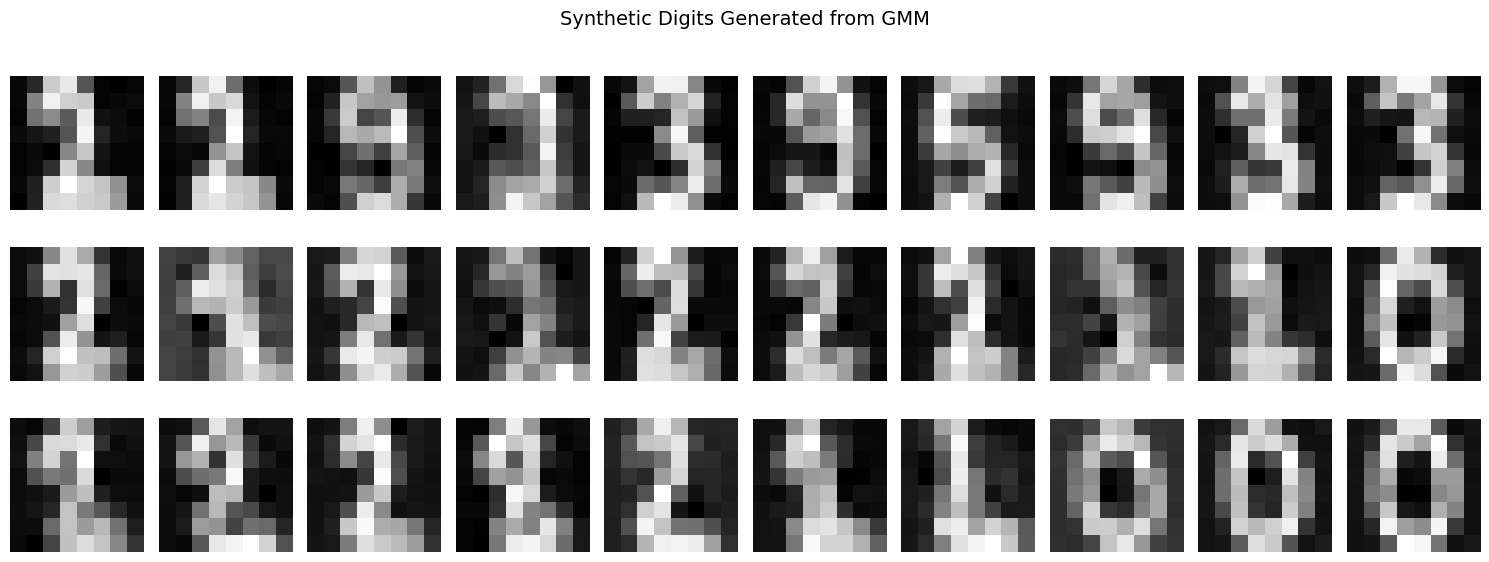


**Quality Assessment:**
The synthetic digits appear... [comment on quality and recognizability]


In [286]:
# Visualize synthetic digits
n_display = 10
fig, axes = plt.subplots(len(bottleneck_sizes), n_display, figsize=(15, 6))

for row_idx, bn_size in enumerate(bottleneck_sizes):
    for i in range(n_display):
        axes[row_idx, i].imshow(synthetic_digits[bn_size][i].reshape(8, 8), cmap='gray')
        axes[row_idx, i].axis('off')
        if i == 0:
            axes[row_idx, i].set_ylabel(f'BN={bn_size}', fontsize=12, rotation=0, ha='right')

plt.suptitle('Synthetic Digits Generated from GMM', fontsize=14)
plt.tight_layout()
plt.show()

print("\n**Quality Assessment:**")
print("The synthetic digits appear... [comment on quality and recognizability]")

# Classifie Performance on synthetic data

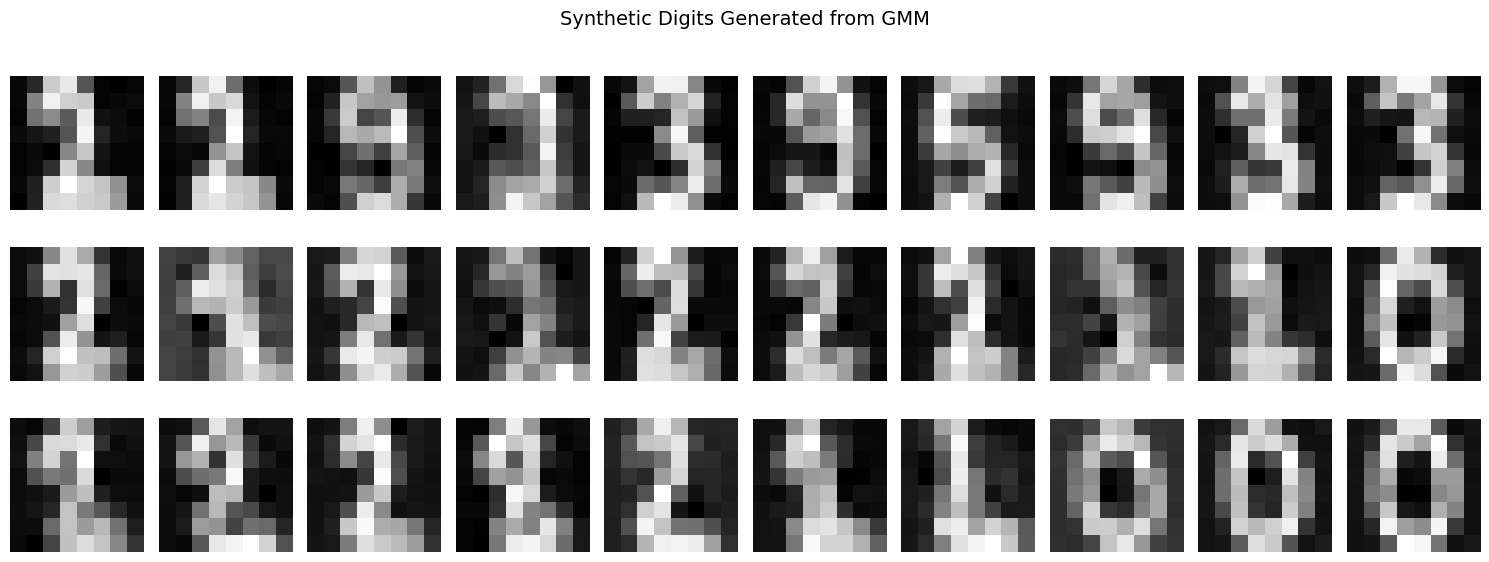


**Quality Assessment:**
The synthetic digits appear... [comment on quality and recognizability]


In [287]:
# Visualize synthetic digits
n_display = 10
fig, axes = plt.subplots(len(bottleneck_sizes), n_display, figsize=(15, 6))

for row_idx, bn_size in enumerate(bottleneck_sizes):
    for i in range(n_display):
        axes[row_idx, i].imshow(synthetic_digits[bn_size][i].reshape(8, 8), cmap='gray')
        axes[row_idx, i].axis('off')
        if i == 0:
            axes[row_idx, i].set_ylabel(f'BN={bn_size}', fontsize=12, rotation=0, ha='right')

plt.suptitle('Synthetic Digits Generated from GMM', fontsize=14)
plt.tight_layout()
plt.show()

print("\n**Quality Assessment:**")
print("The synthetic digits appear... [comment on quality and recognizability]")

/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))
/opt/homebrew/Caskroom/miniconda/base/envs/GNNS/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


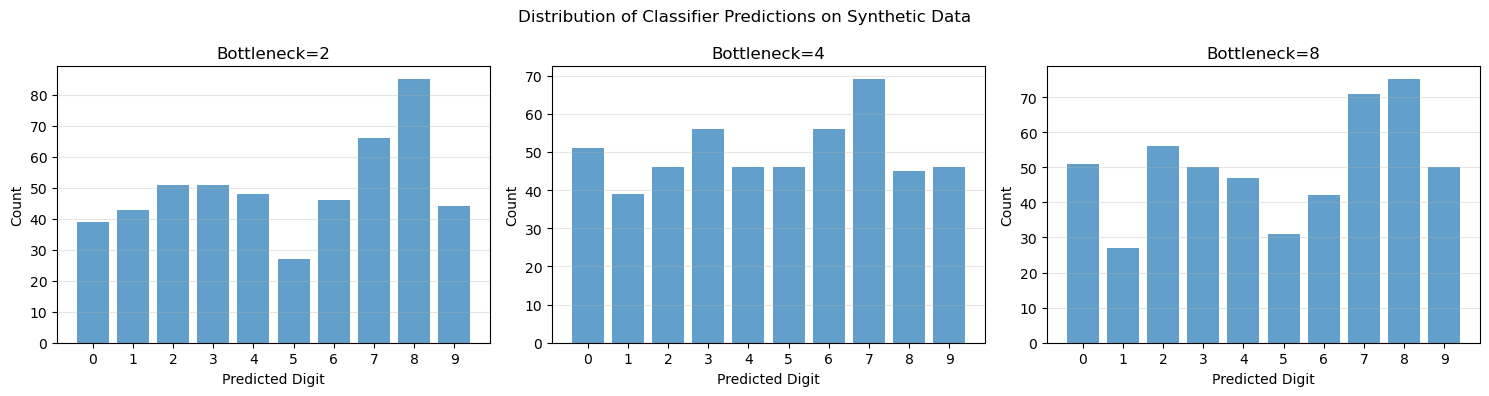


**Final Observations:**
Comparing synthetic to real data, the classifier... [add comparison]
Does the synthetic data agree with what you see? [add your assessment]


In [288]:
# Visualize label distributions
fig, axes = plt.subplots(1, len(bottleneck_sizes), figsize=(15, 4))

for idx, bn_size in enumerate(bottleneck_sizes):
    # Generate and classify
    gmm = gmms[bn_size]
    synthetic_codes, _ = gmm.sample(n_synthetic)
    
    model = models_digits[bn_size]
    model.eval()
    with torch.no_grad():
        synthetic_codes_tensor = torch.FloatTensor(synthetic_codes).to(device)
        synthetic_data = model.decode(synthetic_codes_tensor)
        synthetic_data = synthetic_data.cpu().numpy()
    
    y_synthetic = clf.predict(synthetic_data)
    
    # Plot distribution
    unique, counts = np.unique(y_synthetic, return_counts=True)
    axes[idx].bar(unique, counts, alpha=0.7)
    axes[idx].set_xlabel('Predicted Digit')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'Bottleneck={bn_size}')
    axes[idx].set_xticks(range(10))
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Classifier Predictions on Synthetic Data')
plt.tight_layout()
plt.show()

print("\n**Final Observations:**")
print("Comparing synthetic to real data, the classifier... [add comparison]")
print("Does the synthetic data agree with what you see? [add your assessment]")